In [1]:
import numpy as np
import scipy as sp
from scipy.integrate import cumtrapz as ct
from scipy.special import jv
import matplotlib
from matplotlib import pyplot as plt
import random as rand
import math

# Wiener Process

## !!! returns both the variable as a function of time as well as the normally distributed samples of delta z at each time step !!!

In [ ]:
def wienerProcess(N, T): # total setps, total time
    output = [0.0]
    dt = T/N # calculate dt from the total time and total steps
    for i in range(0,N):
        eps = rand.gauss(0,1)
        delta_z = eps*np.sqrt(dt)
        output.append(delta_z)
    delta_z = np.array(output)
    t = np.linspace(0.0,dt,N+1)
    output = np.cumsum(np.array(delta_z))
#     ct(delta_z,t,initial=0)
    return output, delta_z 

In [ ]:
# quick test
T = 10
N = 10000
zOFt,delta_z_OFt = wienerProcess(N,T)
t = np.linspace(0,T,N+1)

plt.figure(figsize=(14,8))
plt.plot(t,zOFt,label=r'$Z(t)$')
plt.plot(t,delta_z_OFt,linestyle = 'dotted',linewidth=1,label=r'$\Delta Z(t)$')
plt.hlines(0,-1,2*T, linestyle='dashed',linewidth=0.75,color='k')
plt.xlim(-0.001,T+T*0.01)
# plt.ylim(-1,1)
plt.xlabel(r'$t$')
plt.legend(loc='best')
plt.show()

# Generalized Wiener Process

In [ ]:
def generalizedWienerProcess(N, T, a, b): # total setps, total time
    output = [0.0]
    last_step = 0
    dt = T/N # calculate dt from the total time and total steps
    for i in range(0,N):
        eps = rand.gauss(0,1)
        delta_x = a*dt + b*eps*np.sqrt(dt)
        output.append(delta_x)
    delta_x = output
    output = np.cumsum(np.array(delta_x))
    return output, delta_x

In [ ]:
# quick test
T = 10
N = 10000
a = 1
b = 1.5
xOFt,delta_x_OFt = generalizedWienerProcess(N,T,a,b)
t = np.linspace(0,T,N+1)
drift = a*t

plt.figure(figsize=(14,8))
plt.plot(t,xOFt,label=r'$Z(t)$')
plt.plot(t,delta_x_OFt,linestyle = 'dotted',linewidth=1,label=r'$\Delta Z(t)$')
plt.plot(t,drift, linestyle='dashed',linewidth=0.75,color='r',label='Drift')
plt.hlines(0,-1,2*T, linestyle='dashed',linewidth=0.75,color='k')
plt.xlim(-0.001,T+T*0.01)
plt.xlabel(r'$t$')
plt.legend(loc='best')
plt.show()

# "Direct" Ito Process

### First, a few functions that can be passed in for a(x,t) and b(x,t)

In [79]:
# WRAPPER FUNCTIONS FOR a AND b
def A(x,t,params,func):
    return func(x,t,params)
def B(x,t,params,func):
    return func(x,t,params)

# FUNCTIONS FOR A(x,t)
# A(x,t) IS Dx/Dt AND THEREFORE WE NEED TO SPECIFY
# THE DERIVATIVE OF THE DRIFT FUNCTION WE WOULD LIKE
# THE FUNCTIONS ARE NAMED FOR THE DRIFT

def Linear(x,t,A): # LINEAR DRIFT HAS CONSTANT DERIVATIVE
    return A

def oscillate(x,t,params): # DERIVATIVE OF OSCILLATION HAS FREQ FACTOR
    #phase should be set to 0 by boundary condition that
    #X(t) is initially 0, NOT its derivative
    norm,freq = params
    return norm*freq*math.cos(t*freq)

def bessel(x,t,params): #DERIVATIVE OF BESSEL HAS GENERAL FORMULA
    #phase is again set by boundary condition that
    #X(t) is initially 0, NOT its derivative
    #therefore X(t) cannot be j0 and order must be >0
    norm,freq,order = params
    order = int(order)
    if (order < 1):
        raise ValueError('Order of integrated drift for Bessel must be an integer greater than 0')
    else:
        #gernal formula for Bessel derivative at given order
        return 0.5*norm*( jv(order-1,t*freq) - jv(order+1,t*freq) )*freq
    
def damped_oscillate(x,t,params): # DERIVATIVE OF DAMPED OSCILLATOR
    #phase is again set by boundary condtion that
    #X(t) is initially 0, NOT its derivative
    norm,freq,lifetime = params
    return norm*(freq*math.cos(t*freq)*math.exp(-t/lifetime) - math.sin(t*freq)*math.exp(-t/lifetime)/lifetime)

def geometric_A(x,t,params):
    mu = params
    return x*mu

# FUNCTIONS FOR B(x,t)
def power(x,t,params):
    A,p = params
    return A*(t**p)
def Cosin(x,t,params):
    norm,freq,phase = params
    return norm*math.cos(freq*t + phase)
def damped_Cosin(x,t,params):
    norm,freq,phase,lifetime = params
    return Cosin(x,t,(norm,freq,phase))*math.exp(-t/lifetime)
def besselB(x,t,params):
    norm,freq,order = params
    return norm*jv(order,freq*t)
def geometric_B(x,t,params):
    sigma = params
    return x*sigma

In [3]:
def directItoProcess(N, T, Aparams, Afunc, Bparams, Bfunc, S0 = 0.0): # total setps, total time
    output = [S0]
    delta_x = []
    last_step = 0
    dt = T/N # calculate dt from the total time and total steps
    
    eps = rand.gauss(0,1)
    t = dt
    x = S0
    a = A(x,t,Aparams,Afunc)
    b = B(x,t,Bparams,Bfunc)
    dx = a*dt + b*eps*np.sqrt(dt)
    delta_x.append(dx)
    
    for i in range(1,N):
        eps = rand.gauss(0,1)
        x = S0 + np.cumsum(delta_x)[-1]
        t = dt*i+dt
        a = A(x,t,Aparams,Afunc)
        b = B(x,t,Bparams,Bfunc)
        dx = a*dt + b*eps*np.sqrt(dt)
        delta_x.append(dx)
    output.extend(delta_x)
    output = np.cumsum(np.array(output))
    delta_x = np.array(delta_x)
    return output, delta_x

## Examples of different functions and paramters

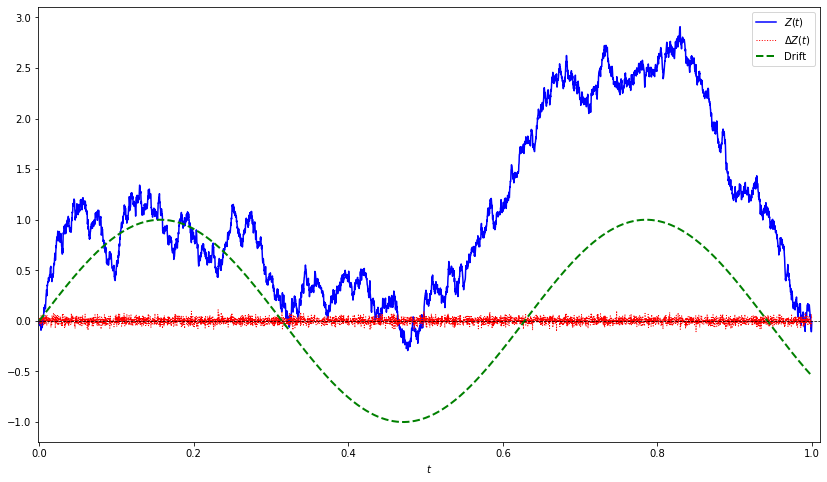

In [71]:
# quick test
N = 5000
T = 1

#oscillate for drift
Afunc = oscillate
norm = 1
freq = 10
Aparams = (norm,freq)

#constant for Wiener
Bfunc = power
Bparams = (2,0)

xOFt,delta_x_OFt = directItoProcess(N,T,Aparams,Afunc,Bparams,Bfunc)
dt = T/N
t = np.linspace(T/N,T,N+1)
drift = np.array([Afunc(0,tt,Aparams)*dt for i,tt in enumerate(t)])
drift = np.cumsum(drift)

# test = np.array([Afunc(0,tt,(1,1,0))*(T/N) for i,tt in enumerate(t)])
# print(oscillate(0,0,(1,1,0)))


plt.figure(figsize=(14,8))
plt.plot(t,xOFt,label=r'$Z(t)$',color='b',linewidth=1.5)
plt.plot(t[:N],delta_x_OFt,linestyle = 'dotted',linewidth=1,color='r',label=r'$\Delta Z(t)$')
plt.plot(t,drift, linestyle='dashed',linewidth=2,color='g',label='Drift')

# plt.plot(t,test,label='test')

plt.hlines(0,-1,2*T, linestyle='dashed',linewidth=0.75,color='k')
plt.xlim(-0.001,T+T*0.01)
plt.xlabel(r'$t$')
plt.legend(loc='best')
plt.show()

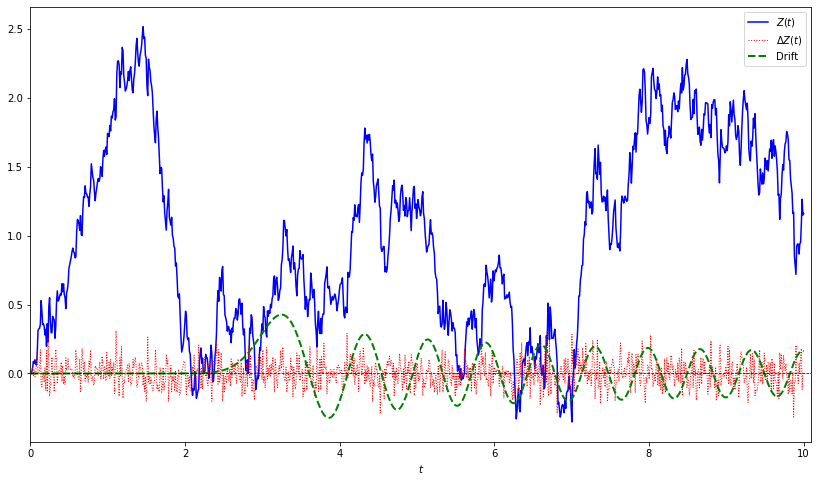

In [72]:
# quick test
N = 1000
T = 10

#oscillate for drift
Afunc = bessel
norm = 2
freq = 10
order = 30
Aparams = (norm,freq,order)

#constant for Wiener
Bfunc = power
Bparams = (1,0)

xOFt,delta_x_OFt = directItoProcess(N,T,Aparams,Afunc,Bparams,Bfunc)
dt = T/N
t = np.linspace(T/N,T,N+1)
drift = np.array([Afunc(0,tt,Aparams)*dt for i,tt in enumerate(t)])
drift = np.cumsum(drift)

plt.figure(figsize=(14,8))
plt.plot(t,xOFt,label=r'$Z(t)$',color='b',linewidth=1.5)
plt.plot(t[:N],delta_x_OFt,linestyle = 'dotted',linewidth=1,color='r',label=r'$\Delta Z(t)$')
plt.plot(t,drift, linestyle='dashed',linewidth=2,color='g',label='Drift')

plt.hlines(0,-1,2*T, linestyle='dashed',linewidth=0.75,color='k')
plt.xlim(-0.001,T+T*0.01)
plt.xlabel(r'$t$')
plt.legend(loc='best')
plt.show()

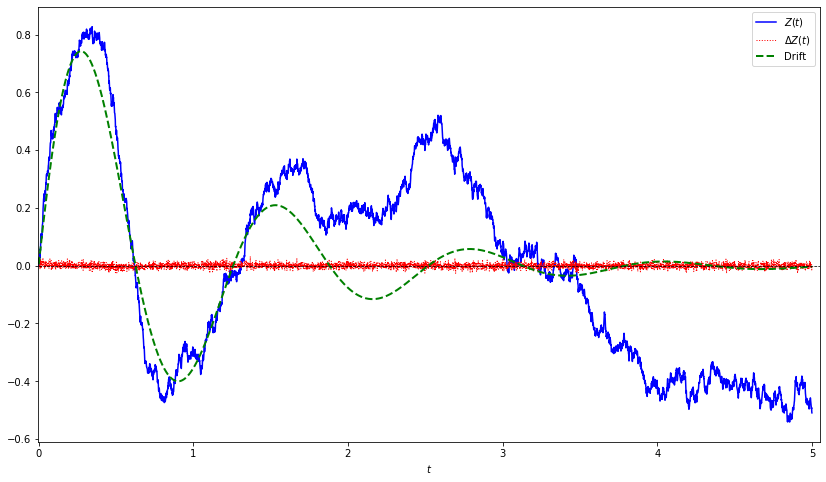

In [73]:
# quick test
N = 5000
T = 5

#oscillate for drift
Afunc = damped_oscillate
norm = 1
freq = 5
lifetime = 1
Aparams = (norm,freq,lifetime)

#constant for Wiener
Bfunc = power
Bparams = (0.25,0)

xOFt,delta_x_OFt = directItoProcess(N,T,Aparams,Afunc,Bparams,Bfunc)
dt = T/N
t = np.linspace(T/N,T,N+1)
drift = np.array([Afunc(0,tt,Aparams)*dt for i,tt in enumerate(t)])
drift = np.cumsum(drift)

plt.figure(figsize=(14,8))
plt.plot(t,xOFt,label=r'$Z(t)$',color='b',linewidth=1.5)
plt.plot(t[1:],delta_x_OFt,linestyle = 'dotted',linewidth=1,label=r'$\Delta Z(t)$',color='r')
plt.plot(t,drift, linestyle='dashed',linewidth=2,color='g',label='Drift')

plt.hlines(0,-1,2*T, linestyle='dashed',linewidth=0.75,color='k')
plt.xlim(-0.001,T+T*0.01)
plt.xlabel(r'$t$')
plt.legend(loc='best')
plt.show()

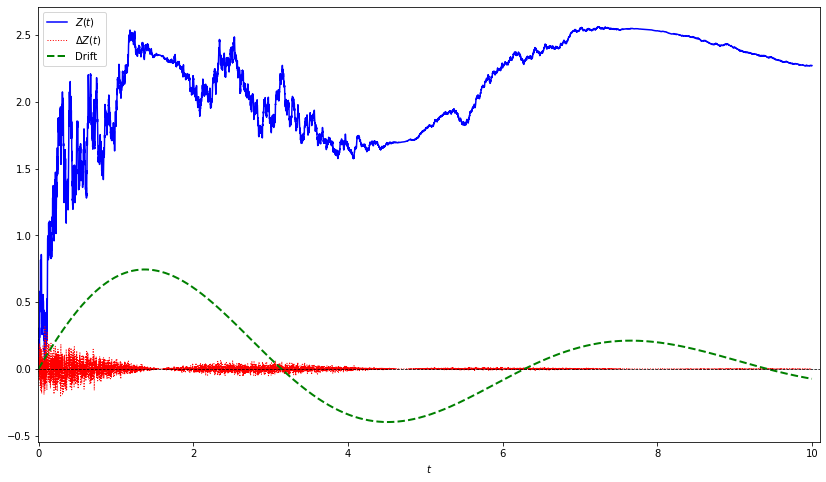

In [7]:
# quick test
N = 10000
T = 10

#oscillate for drift
Afunc = damped_oscillate
norm = 1
freq = 1
lifetime = 5
Aparams = (norm,freq,lifetime)

#constant for Wiener
Bfunc = damped_Cosin
norm = 3
freq = 1
phase = 0
lifetime = 2
Bparams = (norm,freq,phase,lifetime)

xOFt,delta_x_OFt = directItoProcess(N,T,Aparams,Afunc,Bparams,Bfunc)
dt = T/N
t = np.linspace(T/N,T,N+1)
drift = np.array([Afunc(0,tt,Aparams)*dt for i,tt in enumerate(t)])
drift = np.cumsum(drift)

# test = np.array([Afunc(0,tt,(1,1,0))*(T/N) for i,tt in enumerate(t)])
# print(oscillate(0,0,(1,1,0)))


plt.figure(figsize=(14,8))
plt.plot(t,xOFt,label=r'$Z(t)$',color='b',linewidth=1.5)
plt.plot(t[:N],delta_x_OFt,linestyle = 'dotted',linewidth=1,color='r',label=r'$\Delta Z(t)$')
plt.plot(t,drift, linestyle='dashed',linewidth=2,color='g',label='Drift')

# plt.plot(t,test,label='test')

plt.hlines(0,-1,2*T, linestyle='dashed',linewidth=0.75,color='k')
plt.xlim(-0.001,T+T*0.01)
plt.xlabel(r'$t$')
plt.legend(loc='best')
plt.show()

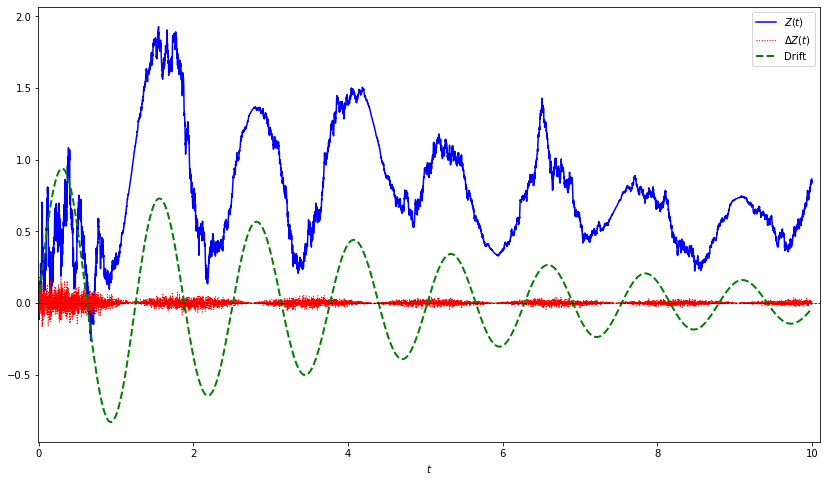

In [8]:
# quick test
N = 10000
T = 10

#oscillate for drift
Afunc = damped_oscillate
norm = 1
freq = 5
lifetime = 5
Aparams = (norm,freq,lifetime)

#constant for Wiener
Bfunc = besselB
norm = 2
freq = 2
order = 0
Bparams = (norm,freq,order)

xOFt,delta_x_OFt = directItoProcess(N,T,Aparams,Afunc,Bparams,Bfunc)
dt = T/N
t = np.linspace(T/N,T,N+1)
drift = np.array([Afunc(0,tt,Aparams)*dt for i,tt in enumerate(t)])
drift = np.cumsum(drift)

# test = np.array([Afunc(0,tt,(1,1,0))*(T/N) for i,tt in enumerate(t)])
# print(oscillate(0,0,(1,1,0)))


plt.figure(figsize=(14,8))
plt.plot(t,xOFt,label=r'$Z(t)$',color='b',linewidth=1.5)
plt.plot(t[:N],delta_x_OFt,linestyle = 'dotted',linewidth=1,color='r',label=r'$\Delta Z(t)$')
plt.plot(t,drift, linestyle='dashed',linewidth=2,color='g',label='Drift')

# plt.plot(t,test,label='test')

plt.hlines(0,-1,2*T, linestyle='dashed',linewidth=0.75,color='k')
plt.xlim(-0.001,T+T*0.01)
plt.xlabel(r'$t$')
plt.legend(loc='best')
plt.show()

## And finally, geometric brownian motion

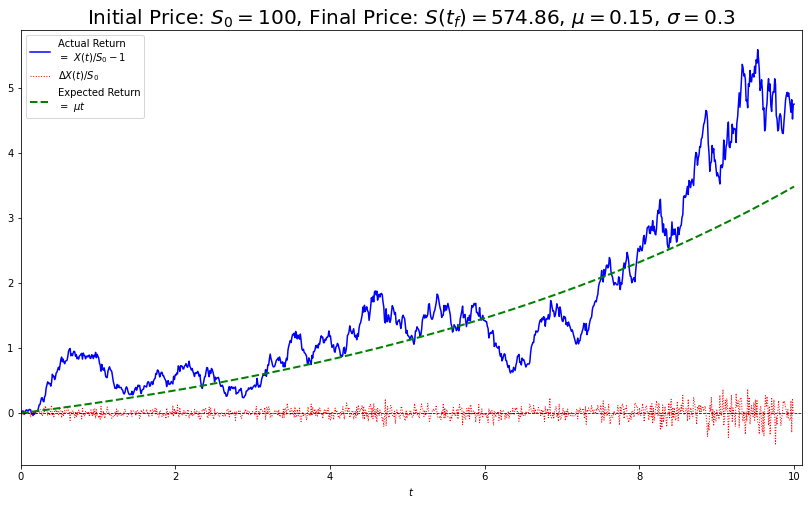

In [45]:
# quick test
N = 1000
T = 10

#oscillate for drift
Afunc = geometric_A
mu = 0.15
Aparams = mu

#constant for Wiener
Bfunc = geometric_B
sigma = 0.3
Bparams = sigma

S0 = 100
xOFt,delta_x_OFt = directItoProcess(N,T,Aparams,Afunc,Bparams,Bfunc,S0)
dt = T/N
t = np.linspace(T/N,T,N+1)
#NOTE: The expected return is independent of stock price. Therefore, we divide out its dependence
# on the stocks price at each point. HOWEVER, we multiply back in the initial stock price
# to scale it to the actual raw dependency i.e. Expected Price instead of return
# drift = np.array([Afunc(xOFt[i],tt,Aparams)*dt/S0 for i,tt in enumerate(t)])
# drift = np.cumsum(drift)
drift = np.exp(mu*t)-1

# test = np.array([Afunc(0,tt,(1,1,0))*(T/N) for i,tt in enumerate(t)])
# print(oscillate(0,0,(1,1,0)))

plt.figure(figsize=(14,8))
plt.rcParams['axes.titlesize'] = 20

# SCALING BY S_0 SO THAT EVERYTHING IS TERMS OF THE RETURN
# ADDITIONALLY NEED TO SUBTRACT OFF THE INITIAL VALUE OF THE STOCK
plt.plot(t,xOFt/S0 - 1,label="Actual Return\n"+r'$=\ X(t)/S_0 - 1$',color='b',linewidth=1.5)
plt.plot(t[:N],delta_x_OFt/S0,linestyle = 'dotted',linewidth=1,color='r',label=r'$\Delta X(t)/S_0$')
plt.plot(t,drift, linestyle='dashed',linewidth=2,color='g',label="Expected Return\n"+r'$=\ \mu t$')

# plt.plot(t,test,label='test')
plt.title(r'Initial Price: $S_0 = {}$, Final Price: $S(t_f) =  {}$, $\mu = {}$, $\sigma = {}$'.format(S0,round(xOFt[-1],2),mu,sigma))
plt.hlines(0,-1,2*T, linestyle='dashed',linewidth=0.75,color='k')
plt.xlim(-0.001,T+T*0.01)
plt.xlabel(r'$t$')
plt.legend(loc='best')

plt.show()

## Ito's lemma applied to futures of stock prices

In [60]:
# assuming for all t_0 = 0 (or T=0, to be notationally consisten with Hull)
# def Future(x,t,r):
#     return x*math.exp(-r*t)

# def dFdx(x,t,r):
#     return math.exp(-r*t)

# # dF^2/dx^2 is 0

# def dFdt(x,t,r):
#     return -r*x*math.exp(-r*t)

def A_F(x,t,params):
    mu,r = params
#     return dFdx(x,t,r)*mu*x + dFdt(x,t,r)
    return (mu-r)*x

def B_F(x,t,sig):
    sigma = sig
#     return sigma*x*dFdx(x,t,r)
    return sigma*x

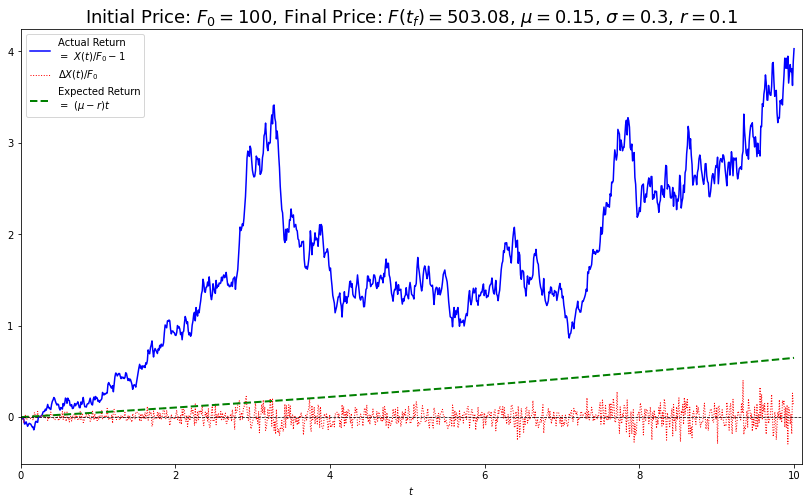

In [91]:
# quick test
N = 1000
T = 10


Afunc = A_F
mu = 0.15
r = 0.1
Aparams = (mu,r)

#constant for Wiener
Bfunc = B_F
sigma = 0.3
Bparams = sigma

F0 = 100
xOFt,delta_x_OFt = directItoProcess(N,T,Aparams,Afunc,Bparams,Bfunc,F0)
dt = T/N
t = np.linspace(T/N,T,N+1)
#NOTE: The expected return is independent of stock price. Therefore, we divide out its dependence
# on the stocks price at each point. HOWEVER, we multiply back in the initial stock price
# to scale it to the actual raw dependency i.e. Expected Price instead of return
# drift = np.array([Afunc(xOFt[i],tt,Aparams)*dt/S0 for i,tt in enumerate(t)])
# drift = np.cumsum(drift)
drift = np.exp((mu-r)*t)-1

# test = np.array([Afunc(0,tt,(1,1,0))*(T/N) for i,tt in enumerate(t)])
# print(oscillate(0,0,(1,1,0)))

plt.figure(figsize=(14,8))
plt.rcParams['axes.titlesize'] = 18

# SCALING BY S_0 SO THAT EVERYTHING IS TERMS OF THE RETURN
# ADDITIONALLY NEED TO SUBTRACT OFF THE INITIAL VALUE OF THE STOCK
plt.plot(t,xOFt/F0 - 1,label="Actual Return\n"+r'$=\ X(t)/F_0 - 1$',color='b',linewidth=1.5)
plt.plot(t[:N],delta_x_OFt/F0,linestyle = 'dotted',linewidth=1,color='r',label=r'$\Delta X(t)/F_0$')
plt.plot(t,drift, linestyle='dashed',linewidth=2,color='g',label="Expected Return\n"+r'$=\ (\mu-r) t$')

# plt.plot(t,test,label='test')
plt.title(r'Initial Price: $F_0 = {}$, Final Price: $F(t_f) =  {}$, $\mu = {}$, $\sigma = {}$, $r = {}$'.format(F0,round(xOFt[-1],2),mu,sigma,r))
plt.hlines(0,-1,2*T, linestyle='dashed',linewidth=0.75,color='k')
plt.xlim(-0.001,T+T*0.01)
plt.xlabel(r'$t$')
plt.legend(loc='best')

plt.show()

## Lognormal

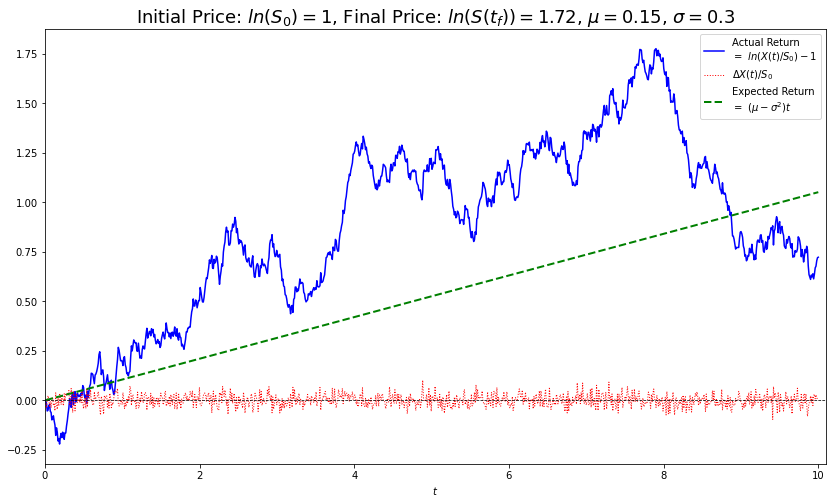

In [95]:
# quick test
N = 1000
T = 10


Afunc = Linear
mu = 0.15
sigma = 0.3
a = mu-(sigma**2)/2
Aparams = a

#constant for Wiener
Bfunc = power
Bparams = (sigma,0)

S0 = 1
xOFt,delta_x_OFt = directItoProcess(N,T,Aparams,Afunc,Bparams,Bfunc,S0)
dt = T/N
t = np.linspace(T/N,T,N+1)

drift = np.array([Afunc(xOFt[i],tt,Aparams)*dt/S0 for i,tt in enumerate(t)])
drift = np.cumsum(drift)
# drift = np.exp((mu-r)*t)-1

# test = np.array([Afunc(0,tt,(1,1,0))*(T/N) for i,tt in enumerate(t)])
# print(oscillate(0,0,(1,1,0)))

plt.figure(figsize=(14,8))
plt.rcParams['axes.titlesize'] = 18

# SCALING BY S_0 SO THAT EVERYTHING IS TERMS OF THE RETURN
# ADDITIONALLY NEED TO SUBTRACT OFF THE INITIAL VALUE OF THE STOCK
plt.plot(t,xOFt/S0 - 1,label="Actual Return\n"+r'$=\ ln(X(t)/S_0) - 1$',color='b',linewidth=1.5)
plt.plot(t[:N],delta_x_OFt/S0,linestyle = 'dotted',linewidth=1,color='r',label=r'$\Delta X(t)/S_0$')
plt.plot(t,drift, linestyle='dashed',linewidth=2,color='g',label="Expected Return\n"+r'$=\ (\mu-\sigma^2) t$')

# plt.plot(t,test,label='test')
plt.title(r'Initial Price: $ln(S_0) = {}$, Final Price: $ln(S(t_f)) =  {}$, $\mu = {}$, $\sigma = {}$'.format(S0,round(xOFt[-1],2),mu,sigma,r))
plt.hlines(0,-1,2*T, linestyle='dashed',linewidth=0.75,color='k')
plt.xlim(-0.001,T+T*0.01)
plt.xlabel(r'$t$')
plt.legend(loc='best')

plt.show()